# Quick MCMC tutorial
Here we'll show how to run a simple Markov Chain Monte Carlo simulation to infer a planet's surface map from a dataset containing its phase curve and its secondary eclipse. For simplicity, we assume the orbital parameters and the size of the planet are known **exactly**. The map is composed of first-order spherical harmonics and is therefore a simple dipole map. The luminosity of the planet is assumed to be known, so the $Y_{0,0}$ coefficient is fixed at unity (this is **starry** default behavior for **Planet** instances) and we will solve for the three first order coefficients: $Y_{1,-1}$, $Y_{1,0}$, and $Y_{1,1}$.

Let's begin by importing some stuff:

In [14]:
from starry import Planet, Star, System
import emcee
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm
import corner
np.random.seed(1234)

In [15]:
%matplotlib inline

Let's define some functions to easily generate and set the planet map coefficients:

In [16]:
def set_coeffs(p, planet):
    """Set the coefficients of the planet map."""
    y1m1, y10, y11 = p
    planet.map[1, -1] = y1m1
    planet.map[1, 0] = y10
    planet.map[1, 1] = y11


def gen_coeffs():
    """Generate random initial conditions."""
    y1m1 = np.random.randn()
    y10 = np.random.randn()
    y11 = np.random.randn()
    return [y1m1, y10, y11]

Here we define our log probability and log prior for use in the MCMC run. These are super simple: we're essentially computing the chi squared metric for our model:

In [17]:
def lnprior(p):
    """Loosely informative log prior probability."""
    if np.any(p < -5) or np.any(p > 5):
        return -np.inf
    else:
        return 0


def lnlike(p, time, y, yerr, system, planet):
    """Log likelihood."""
    ll = lnprior(p)
    if np.isinf(ll):
        return ll

    # Set the coeffs and compute the flux
    set_coeffs(p, planet)
    system.compute(time)

    # Compute the chi-squared
    chisq = np.sum((y - system.flux) ** 2) / yerr ** 2
    ll += -0.5 * chisq

    return ll

Now, some code to generate a synthetic light curve. Note that we add extra resolution at secondary eclipse ingress and egress, since that's where most of the information is!

In [18]:
def generate(x, tstart=1, tend=5.3, npts=100, ning=100, neg=100):
    """Generate a synthetic light curve."""
    # Instantiate the star (params known exactly)
    star = Star()
    star.map[1] = 0.4
    star.map[2] = 0.26

    # Instantiate the planet
    planet = Planet(lmax=1,
                    lambda0=270,
                    r=0.0916,
                    L=5e-3,
                    inc=87,
                    a=11.12799,
                    prot=4.3,
                    porb=4.3,
                    tref=2)

    # Instantiate the system
    system = System([star, planet])

    # Set the map coeffs
    set_coeffs(x, planet)

    # Time array w/ extra resolution at ingress/egress
    ingress = (1.94, 1.96)
    egress = (2.04, 2.06)
    time = np.linspace(tstart, tend, npts)
    if ingress is not None:
        t = np.linspace(ingress[0], ingress[1], ning)
        time = np.append(time, t)
    if egress is not None:
        t = np.linspace(egress[0], egress[1], neg)
        time = np.append(time, t)
    time = time[np.argsort(time)]

    # Compute and plot the starry flux
    system.compute(time)
    flux = np.array(system.flux)

    # Noise it
    yerr = 1e-4 * np.nanmedian(flux)
    y = flux + yerr * np.random.randn(len(flux))

    # Compute the flux at hi res for plotting
    time_hires = np.linspace(tstart, tend, npts * 100)
    system.compute(time_hires)
    flux_hires = np.array(system.flux)
    
    return time, y, yerr, star, planet, system, time_hires, flux_hires

Finally, let's define the **true** values for the map coefficients, which we will try to infer:

In [19]:
# These are the values we're going to try to recover
y1m1 = 0.20
y10 = 0.30
y11 = 0.20
truth = np.array([y1m1, y10, y11])
labels = np.array([r"$Y_{1,-1}$", r"$Y_{1,0}$", r"$Y_{1,1}$"])

Generate the data and plot it, alongside our initial model guesses for the MCMC chain:

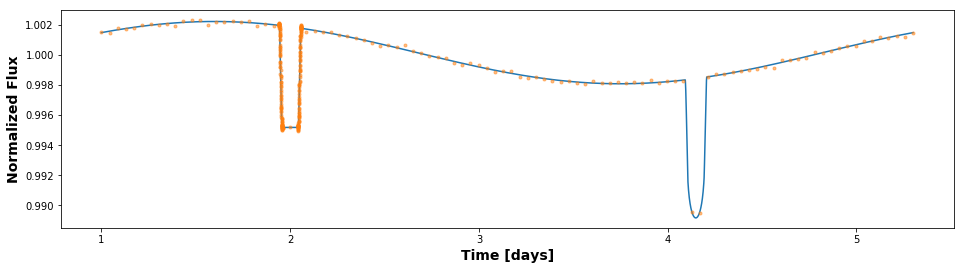

In [20]:
# Generate synthetic data
time, y, yerr, star, planet, system, time_hires, flux_hires = generate(truth)

# Set the initial conditions
nburn = 500
nsteps = 1000
nwalk = 30
ndim = len(truth)
p0 = [gen_coeffs() for k in range(nwalk)]

# Plot the true model and our noised data
fig, ax = pl.subplots(1, figsize=(16, 4))
norm = np.nanmedian(flux_hires)
ax.plot(time_hires, flux_hires / norm, '-', color='C0')
ax.plot(time, y / norm, '.', color='C1', alpha=0.5)
ax.set_xlabel('Time [days]', fontsize=14, fontweight='bold');
ax.set_ylabel('Normalized Flux', fontsize=14, fontweight='bold');

Now, on to the good stuff!

## Run the MCMC chain

In [21]:
# Run our MCMC chain
sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike,
                                args=[time, y, yerr, system, planet])
for i in tqdm(sampler.sample(p0, iterations=nsteps), total=nsteps):
    pass

# Get the maximum likelihood sample
maxlike = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

100%|██████████| 1000/1000 [00:13<00:00, 74.37it/s]


## Plot the chains

They look great! The blue lines are the **true** values.

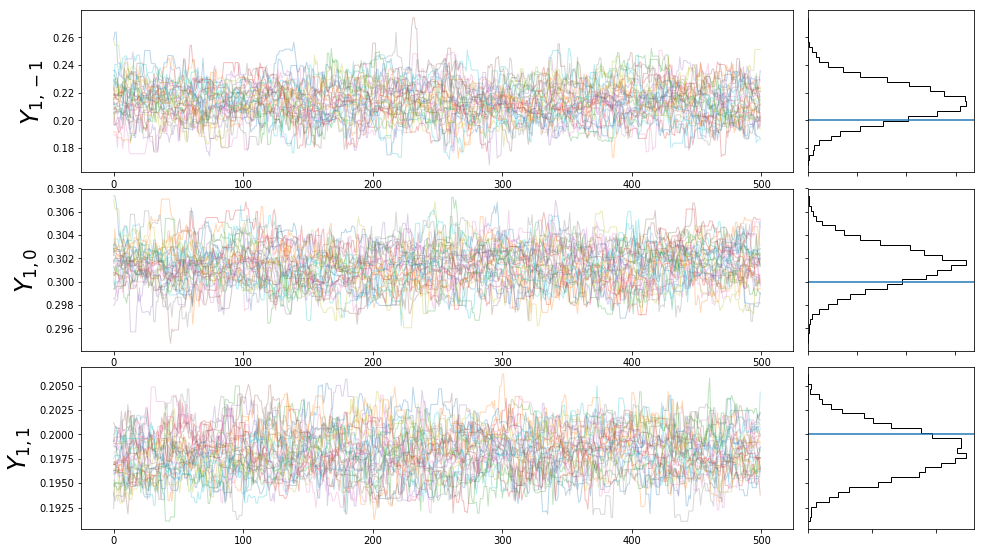

In [22]:
# Plot the chains w/out the burn-in
fig = pl.figure(figsize=(16, 8))
fig.subplots_adjust(bottom=0.05, top=0.95, hspace=0.1)
axc = [pl.subplot2grid((ndim, 10), (n, 0), colspan=8, rowspan=1)
       for n in range(ndim)]
axh = [pl.subplot2grid((ndim, 10), (n, 8), colspan=2,
                       rowspan=1, sharey=axc[n]) for n in range(ndim)]
alpha = 0.3
for i, label in enumerate(labels):
    for k in range(nwalk):
        axc[i].plot(sampler.chain[k, nburn:, i], alpha=alpha, lw=1)
        axc[i].set_ylabel(label, fontsize=24)
    axh[i].hist(sampler.chain[:, nburn:, i].flatten(), bins=30,
                orientation="horizontal", histtype='step',
                fill=False, color='k', lw=1)
    pl.setp(axh[i].get_yticklabels(), visible=False)
    pl.setp(axh[i].get_xticklabels(), visible=False)
    axh[i].axhline(truth[i], color='C0')

## Plot the posteriors

Again, the blue lines are the true values. Our posteriors are nice and gaussian, and it looks like we nailed the solution!

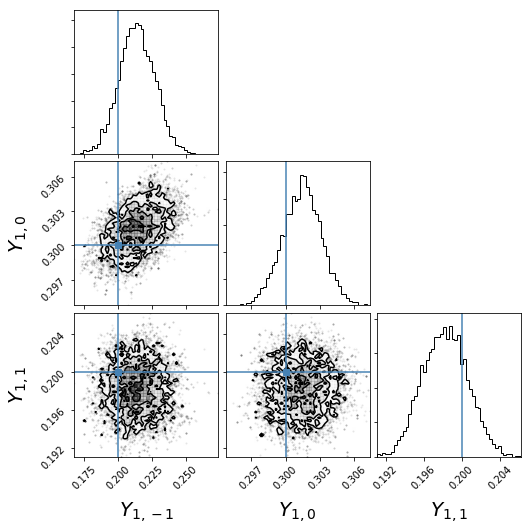

In [23]:
# Plot the corner plot
samples = sampler.chain[:, nburn:, :].reshape(nwalk * (nsteps - nburn), ndim)
fig = corner.corner(samples, labels=labels, bins=50, truths=truth);
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

## Plot the maximum likelihood map

We successfully mapped this planet's dipole :)

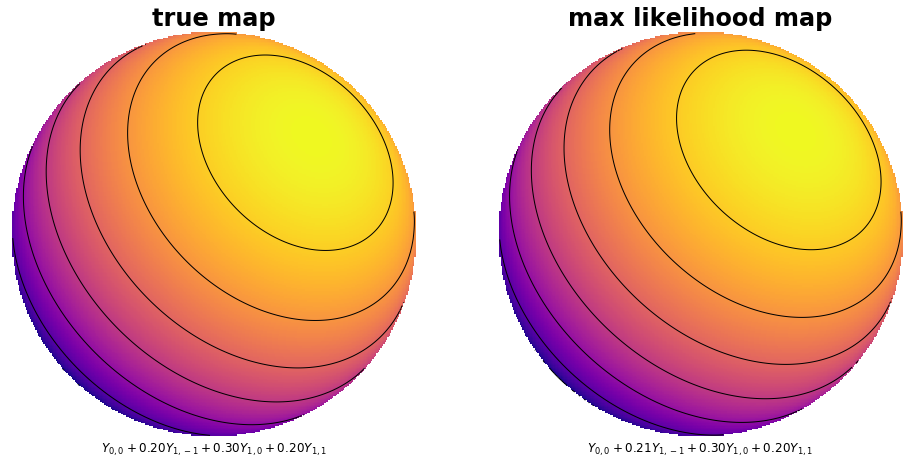

In [26]:
# Plot the original map and the maximum likelihood map
fig, ax = pl.subplots(1, 2, figsize=(16, 8))
x, y = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
set_coeffs(truth, planet)
img = [planet.map.evaluate(x=x[j], y=y[j]) for j in range(300)]
ax[0].imshow(img, origin="lower",
             interpolation="none", cmap="plasma",
             extent=(-1, 1, -1, 1))
ax[0].contour(img, origin="lower",
              extent=(-1, 1, -1, 1),
              colors='k', linewidths=1)
ax[0].set_frame_on(False)
ax[0].set_xticks([])
ax[0].set_yticks([])
expr = r"${0}$".format(planet.map.__repr__()[12:-1])
ax[0].set_xlabel(expr, fontsize=12)
ax[0].set_title("true map", fontsize=24, fontweight='bold');
set_coeffs(maxlike, planet)
img = [planet.map.evaluate(x=x[j], y=y[j]) for j in range(300)]
ax[1].imshow(img, origin="lower",
             interpolation="none", cmap="plasma",
             extent=(-1, 1, -1, 1))
ax[1].contour(img, origin="lower",
              extent=(-1, 1, -1, 1),
              colors='k', linewidths=1)
ax[1].set_frame_on(False)
ax[1].set_xticks([])
ax[1].set_yticks([])
expr = r"${0}$".format(planet.map.__repr__()[12:-1])
ax[1].set_xlabel(expr, fontsize=12)
ax[1].set_title("max likelihood map", fontsize=24, fontweight='bold');